In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

from patsy import dmatrix
from statsmodels.gam.smooth_basis import BSplines
from statsmodels.stats.outliers_influence import summary_table
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [2]:
wages = pd.read_csv('../data/wage.csv')
wages.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [3]:
# checking if there is any missing value
pd.isnull(wages).any()

year          False
age           False
maritl        False
race          False
education     False
region        False
jobclass      False
health        False
health_ins    False
logwage       False
wage          False
dtype: bool

## 7.8.1 Polynomial Regression and Step Functions

In [4]:
model = smf.ols('wage ~ age + I(age**2) + I(age**3) + I(age**4)', data=wages).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
age,21.2455,5.887,3.609,0.000,9.703,32.788
I(age ** 2),-0.5639,0.206,-2.736,0.006,-0.968,-0.160
I(age ** 3),0.0068,0.003,2.221,0.026,0.001,0.013
I(age ** 4),-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


In [5]:
# generate sequance of age values spanning the range
agelims = np.arange(wages.age.min(), wages.age.max())

# predict the value of the generated ages
preds = model.predict(dict(age=agelims))

In [6]:
# The methods returns standard errors and confidence intervals for a given array X
simple_table, data, columns = summary_table(model, alpha=0.05)
columns

['Obs',
 'Dep Var\nPopulation',
 'Predicted\nValue',
 'Std Error\nMean Predict',
 'Mean ci\n95% low',
 'Mean ci\n95% upp',
 'Predict ci\n95% low',
 'Predict ci\n95% upp',
 'Residual',
 'Std Error\nResidual',
 'Student\nResidual',
 "Cook's\nD"]

In [7]:
# Columns 4 'Mean ci\n95% low', and 5 'Mean ci\n95% upp' gives the confidence intervals
mean_ci_low, mean_ci_upp = data[:, 4:6].T

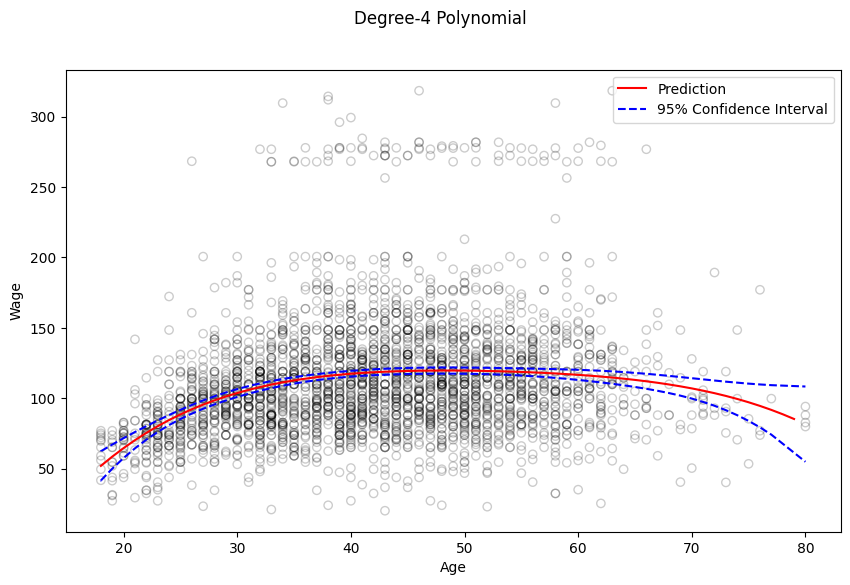

In [8]:
fig, axes = plt.subplots(1,1, figsize=(10,6))
fig.suptitle('Degree-4 Polynomial')

axes.scatter(wages.age, wages.wage, facecolors='None', edgecolors='k', alpha=0.2)
axes.plot(agelims, preds, color='r', label='Prediction')

# this method returns the indices that would sort an array
idx_order = np.argsort(wages.age.values)

# plot the confidence intervals
axes.plot(wages.age.values[idx_order], mean_ci_low[idx_order], color='b', linestyle='dashed', label='95% Confidence Interval')
axes.plot(wages.age.values[idx_order], mean_ci_upp[idx_order], color='b', linestyle='dashed')

axes.legend(loc='best');
axes.set_xlabel('Age');
axes.set_ylabel('Wage');

In performing a polynomial regression we must decide on the degree of the polynomial to use. One way to do this is by using hypothesis tests. We now fit models ranging from linear to a degree-5 polynomial and seek to determine the simplest model which is sufficiet to explain the relationship between `wage` and `age`.

In [9]:
poly = PolynomialFeatures(degree=5, interaction_only=False, include_bias=False)
X = poly.fit_transform(wages.age.values.reshape(-1, 1))

df = pd.DataFrame({'age':wages.age.values, 'age2':X[:, 1],
                   'age3': X[:, 2], 'age4': X[:, 3],
                   'age5': X[:, 4], 'wage': wages.wage.values})

In [10]:
fit1 = smf.ols('wage ~ age', data=df).fit()
fit2 = smf.ols('wage ~ age + age2', data=df).fit()
fit3 = smf.ols('wage ~ age + age2 + age3', data=df).fit()
fit4 = smf.ols('wage ~ age + age2 + age3 + age4', data=df).fit()
fit5 = smf.ols('wage ~ age + age2 + age3 + age4 + age5', data=df).fit()
table = sm.stats.anova_lm(fit1, fit2, fit3, fit4, fit5, type=1)
table

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


According to the anova table given above, a `cubic` or a `quartic` polynomial appear to provide a reasonable fit to the data, but lower-order or higher-order models are not justified.

In [11]:
# Now we consider the task of predicting whether an individual earns more 
# than $250,000 per year.

df['wage_250'] = (wages.wage > 250).astype(float)
logit = smf.logit('wage_250 ~ age + age2 + age3 + age4', df).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.116870
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               wage_250   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2995
Method:                           MLE   Df Model:                            4
Date:                Tue, 16 May 2023   Pseudo R-squ.:                 0.04013
Time:                        01:46:24   Log-Likelihood:                -350.61
converged:                       True   LL-Null:                       -365.27
Covariance Type:            nonrobust   LLR p-value:                 6.747e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -109.5530     47.655     -2.299      0.022    -202.956     -16.150
age            8.9950      4.187      2.148      0.032       0.789      17.201
age2          -0.2816      0.135     -2.081      0.037      -0.547      -0.016
age3           0.0039      0.002      2.022      0.043       0.000       0.008
age4       -1.949e-05   9.91e-06     -1.966      0.049   -3.89e-05   -6.41e-08
==============================================================================
"""

In [12]:
# generate a test set
X_test = pd.DataFrame(PolynomialFeatures(4, include_bias=True).fit_transform(agelims.reshape(-1, 1)),
                      columns=['Intercept', 'age', 'age2', 'age3', 'age4'])

preds = logit.predict(X_test)

In [13]:
# Get the covariance matrix from the model class
C = logit.normalized_cov_params
C = np.matrix(C)

std_err = np.array([])
# Compute the pointwise standard error
for row in X_test.iterrows():
    L_T = np.array([1, row[1]['age'], row[1]['age2'], row[1]['age3'], row[1]['age4']])

    L_T = np.matrix(L_T)
    L = np.transpose(L_T)
    
    var_f = np.matmul(np.matmul(L_T, C), L)
    var_f = np.asarray(var_f)[0][0]
    pointwise_se = np.sqrt(var_f)
    std_err = np.append(std_err, pointwise_se)

In [14]:
def _logit(p):
    return np.log(p/(1-p))

def _invlogit(x):
    # inverse function of logit
    return 1/(1+np.exp(-x))

# t_alpha/2 (alpha=0.05) => critical value = 1.96
upper_limit = _invlogit(_logit(preds)+1.96*std_err)
lower_limit = _invlogit(_logit(preds)-1.96*std_err)

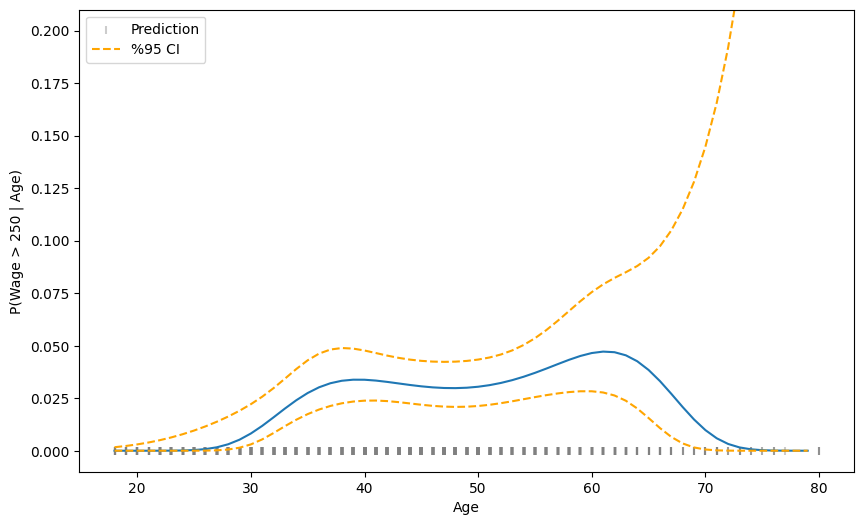

In [15]:
fig, axes = plt.subplots(1,1, figsize=(10,6))

# scaled plot of wage_250 features
axes.scatter(wages.age.values, df['wage_250'].values, marker='|', 
             color='gray', alpha=0.4, label='Prediction')
axes.plot(agelims, preds)
axes.plot(agelims, upper_limit, color='orange', linestyle='dashed', label='%95 CI')
axes.plot(agelims, lower_limit, color='orange', linestyle='dashed')

axes.legend(loc='best');
axes.set_xlabel('Age');
axes.set_ylabel('P(Wage > 250 | Age)');
axes.set_ylim([-.01,0.21]);

### Step Function

In [16]:
# In order to fit a step function, we use the cut() function
age_step, bins = pd.cut(wages.age, 4, retbins=True, right=True)
age_step.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

In [17]:
# Create dummy variable for the age steps
age_step_dummies = pd.get_dummies(age_step)

# Add intercept term into dummy variable table
age_step_dummies = sm.add_constant(age_step_dummies)

# Drop one of the columns of dummy table
age_steps_dummies = age_step_dummies.drop(age_step_dummies.columns[1], axis=1)

age_steps_dummies.head()

,const,"(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1.0,0,0,0
1,1.0,0,0,0
2,1.0,1,0,0
3,1.0,1,0,0
4,1.0,0,1,0


In [18]:
step_func = sm.OLS(df.wage, age_steps_dummies).fit()
step_func.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.264,97.053
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.466,27.641
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.610,27.719
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.139,17.420


The `age < 33.5` category is left out, so the intercept coefficient of $94,160 can be interpreted as the average salary for those under 33.5 years of age, and the other coefficients can be interpreted as the average additional salary for those in the other age groups.

In [19]:
age_step_bins = np.digitize(agelims.ravel(), bins)
X_test = pd.get_dummies(age_step_bins).drop(1, axis=1)

pred = step_func.predict(sm.add_constant(X_test))

In [20]:
# The methods returns standard errors and confidence intervals for a given array X
simple_table, data, columns = summary_table(step_func, alpha=0.05)
mean_ci_low, mean_ci_upp = data[:, 4:6].T

Text(0, 0.5, 'Wage')

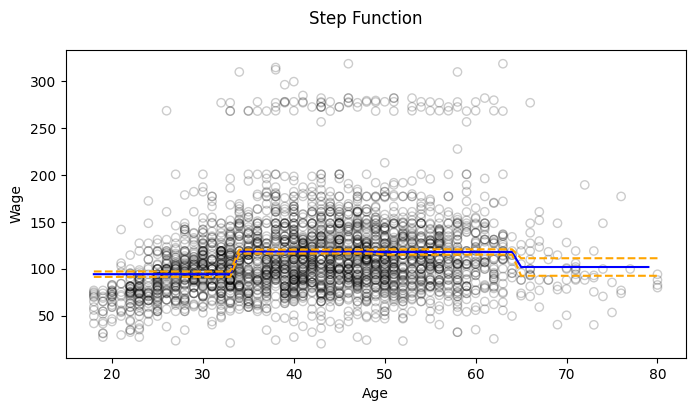

In [22]:
fig, axes = plt.subplots(1,1, figsize=(8,4))
fig.suptitle('Step Function')

axes.scatter(wages.age, wages.wage, facecolors='None', edgecolors='k', alpha=0.2)
axes.plot(agelims, pred, color='b')

# plot the confidence intervals
idx_order = np.argsort(wages.age.values)
axes.plot(wages.age.values[idx_order], mean_ci_low[idx_order], color='orange', linestyle='dashed', label='95% Confidence Interval')
axes.plot(wages.age.values[idx_order], mean_ci_upp[idx_order], color='orange', linestyle='dashed')

axes.set_xlabel('Age')
axes.set_ylabel('Wage')

## 7.8.2 Splines

In [23]:
age_spline = dmatrix('bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)', 
                     data=wages, return_type='dataframe')

agelims_spline = dmatrix('bs(agelims, knots=(25, 40, 60), degree=3, include_intercept=False)',
                        {'agelims': agelims}, return_type='dataframe')

age_spline.head()

,Intercept,"bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]","bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]","bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]","bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]","bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]","bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]"
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1.0,0.559911,0.403778,0.033395,0.000000,0.000000,0.0
2,1.0,0.000000,0.114796,0.618564,0.262733,0.003906,0.0
3,1.0,0.000000,0.167109,0.633167,0.198880,0.000844,0.0
4,1.0,0.000000,0.034014,0.508194,0.426542,0.031250,0.0


Here we have prespecified knots at 25, 40, 60. This produces a spline with six basis functions. (Recall that a cubic spline with three knots has seven degrees of freedom; these degrees of freedom are used up by an intercept, plus six basis functions.)

In [24]:
spline_model = sm.OLS(wages.wage, age_spline).fit()
pred = spline_model.predict(agelims_spline)

In [25]:
# The methods returns standard errors and confidence intervals for a given array X
simple_table, data, columns = summary_table(spline_model, alpha=0.05)
mean_ci_low, mean_ci_upp = data[:, 4:6].T

Text(0, 0.5, 'Wage')

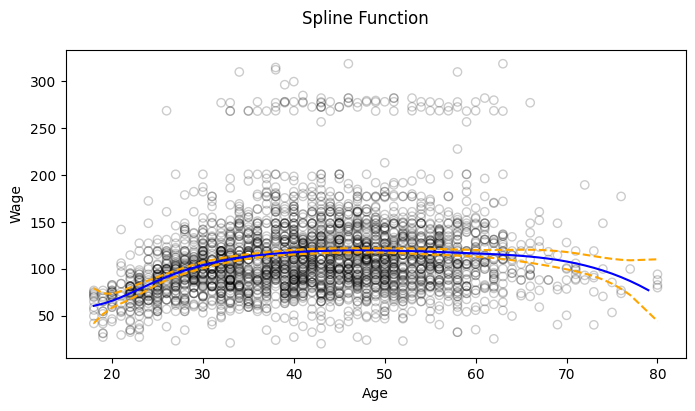

In [26]:
fig, axes = plt.subplots(1,1, figsize=(8,4))
fig.suptitle('Spline Function')

axes.scatter(wages.age, wages.wage, facecolors='None', edgecolors='k', alpha=0.2)
axes.plot(agelims, pred, color='b')

# plot the confidence intervals
idx_order = np.argsort(wages.age.values)
axes.plot(wages.age.values[idx_order], mean_ci_low[idx_order], color='orange', linestyle='dashed', label='95% Confidence Interval')
axes.plot(wages.age.values[idx_order], mean_ci_upp[idx_order], color='orange', linestyle='dashed')

axes.set_xlabel('Age')
axes.set_ylabel('Wage')

### Natural Spline

In [27]:
age_spline2 = dmatrix('cr(age, df=4)', data=wages, return_type='dataframe')
agelims_spline2 = dmatrix('cr(agelims, df=4)', {'agelims': agelims}, return_type='dataframe')

spline_model2 = sm.OLS(wages.wage, age_spline2).fit()
pred2 = spline_model2.predict(agelims_spline2)

In [28]:
# The methods returns standard errors and confidence intervals for a given array X
simple_table, data, columns = summary_table(spline_model, alpha=0.05)
mean_ci_low, mean_ci_upp = data[:, 4:6].T

Text(0, 0.5, 'Wage')

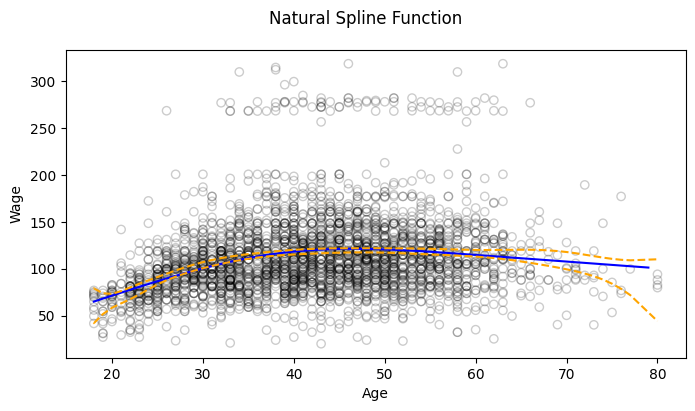

In [29]:
fig, axes = plt.subplots(1,1, figsize=(8,4))
fig.suptitle('Natural Spline Function')

axes.scatter(wages.age, wages.wage, facecolors='None', edgecolors='k', alpha=0.2)
axes.plot(agelims, pred2, color='b')

# plot the confidence intervals
idx_order = np.argsort(wages.age.values)
axes.plot(wages.age.values[idx_order], mean_ci_low[idx_order], color='orange', linestyle='dashed', label='95% Confidence Interval')
axes.plot(wages.age.values[idx_order], mean_ci_upp[idx_order], color='orange', linestyle='dashed')

axes.set_xlabel('Age')
axes.set_ylabel('Wage')

### Smoothing Spline

I couldn't find any way to implement smoothing splines in Python.

## 7.8.3 GAMs

We now fit a GAM to predict wage using natural spline functions of `year` and `age`, treating `education` as a qualitative predictor

In [30]:
df = dmatrix("cr(year, df=4, constraints='center') + cr(age, df=5, constraints='center') + education",
            data = wages, return_type='dataframe')
df.head()

,Intercept,education[T.2. HS Grad],education[T.3. Some College],education[T.4. College Grad],education[T.5. Advanced Degree],"cr(year, df=4, constraints='center')[0]","cr(year, df=4, constraints='center')[1]","cr(year, df=4, constraints='center')[2]","cr(year, df=4, constraints='center')[3]","cr(age, df=5, constraints='center')[0]","cr(age, df=5, constraints='center')[1]","cr(age, df=5, constraints='center')[2]","cr(age, df=5, constraints='center')[3]","cr(age, df=5, constraints='center')[4]"
0,1.0,0.0,0.0,0.0,0.0,-0.163729,0.875408,-0.134574,-0.098130,-0.501258,-0.695111,-0.500457,-0.097924,-0.005629
1,1.0,0.0,0.0,1.0,0.0,0.589322,-0.388702,-0.208715,-0.187743,0.400144,-0.615868,-0.284361,-0.074217,-0.002268
2,1.0,0.0,1.0,0.0,0.0,-0.556162,-0.423217,-0.457127,-0.333333,-0.442366,0.425086,-0.060139,-0.123961,0.004613
3,1.0,0.0,0.0,1.0,0.0,-0.556162,-0.423217,-0.457127,-0.333333,-0.381726,0.529486,-0.252171,-0.081935,-0.001216
4,1.0,1.0,0.0,0.0,0.0,0.593776,0.256291,-0.227666,-0.087802,-0.375444,-0.024413,0.505666,-0.175527,0.013195


In [31]:
# Since this is just a big linear regression model using an appropriate choice of basis function,
# we can simply fit a linear model

gam = sm.OLS(wages.wage, df).fit()
gam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     95.22
Date:                Tue, 16 May 2023   Prob (F-statistic):          1.55e-213
Time:                        01:48:49   Log-Likelihood:                -14930.
No. Observations:                3000   AIC:                         2.989e+04
Df Residuals:                    2986   BIC:                         2.997e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  85.4759      2.155     39.668      0.000      81.251      89.701
education[T.2. HS Grad]                    10.9574      2.430      4.509      0.000       6.193      15.722
education[T.3. Some College]               23.4431      2.562      9.152      0.000      18.420      28.466
education[T.4. College Grad]               38.2330      2.546     15.015      0.000      33.240      43.226
education[T.5. Advanced Degree]            62.4786      2.761     22.626      0.000      57.064      67.893
cr(year, df=4, constraints='center')[0]    -0.0548      1.540     -0.036      0.972      -3.075       2.965
cr(year, df=4, constraints='center')[1]     3.6194      1.504      2.407      0.016       0.671       6.567
cr(year, df=4, constraints='center')[2]     2.2938      1.565      1.466      0.143      -0.775       5.363
cr(year, df=4, constraints='center')[3]     4.5342      1.713      2.647      0.008       1.176       7.893
cr(age, df=5, constraints='center')[0]      7.7241      2.640      2.926      0.003       2.548      12.900
cr(age, df=5, constraints='center')[1]     31.0975      2.688     11.567      0.000      25.826      36.369
cr(age, df=5, constraints='center')[2]     20.7737      2.490      8.342      0.000      15.891      25.656
cr(age, df=5, constraints='center')[3]      6.1212      2.866      2.136      0.033       0.501      11.741
cr(age, df=5, constraints='center')[4]    -28.3309     11.298     -2.508      0.012     -50.483      -6.179
==============================================================================
Omnibus:                     1032.791   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5516.646
Skew:                           1.545   Prob(JB):                         0.00
Kurtosis:                       8.881   Cond. No.                         19.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
gam.params

Intercept                                  85.475913
education[T.2. HS Grad]                    10.957379
education[T.3. Some College]               23.443096
education[T.4. College Grad]               38.232950
education[T.5. Advanced Degree]            62.478611
cr(year, df=4, constraints='center')[0]    -0.054821
cr(year, df=4, constraints='center')[1]     3.619381
cr(year, df=4, constraints='center')[2]     2.293793
cr(year, df=4, constraints='center')[3]     4.534247
cr(age, df=5, constraints='center')[0]      7.724121
cr(age, df=5, constraints='center')[1]     31.097522
cr(age, df=5, constraints='center')[2]     20.773680
cr(age, df=5, constraints='center')[3]      6.121194
cr(age, df=5, constraints='center')[4]    -28.330884
dtype: float64

(-10.0, 10.0)

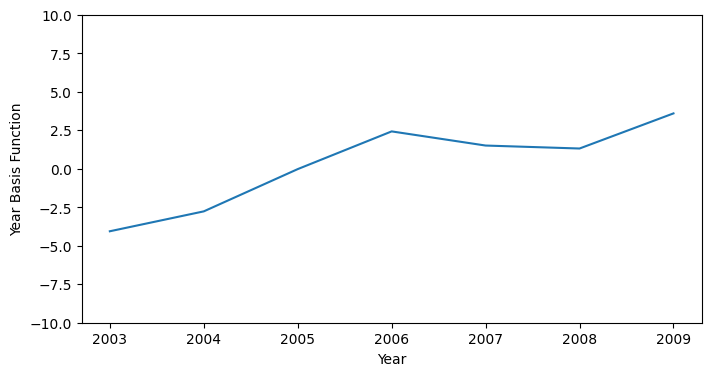

In [33]:
# get the year basis functions
year_basis = df.iloc[:, 5:9]
order = np.argsort(wages.year.values)

fig, axes = plt.subplots(1,1, figsize=(8,4))
# we multiply year basis function values by coefficients (betas)
axes.plot(wages.year[order], np.dot(year_basis.values, gam.params[5:9])[order])

axes.set_xlabel('Year')
axes.set_ylabel('Year Basis Function')
axes.set_ylim([-10, 10])

(-10.0, 10.0)

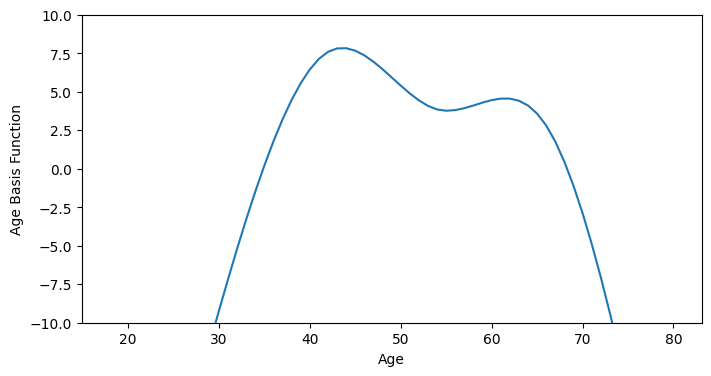

In [34]:
age_basis = df.iloc[:, 9:]
order = np.argsort(wages.age.values)

fig, axes = plt.subplots(1,1, figsize=(8,4))
# we multiply age basis function values by coefficients (betas)
axes.plot(wages.age[order], np.dot(age_basis.values, gam.params[9:])[order])

axes.set_xlabel('Age')
axes.set_ylabel('Age Basis Function')
axes.set_ylim([-10, 10])

In [35]:
edu_basis = df.iloc[:, 1:5]
edu_coef = gam.params[1:5]

df['ed_basis'] = np.dot(edu_basis.values, edu_coef)
df['ed_basis'] = df['ed_basis'] - df['ed_basis'].mean()
df['education'] = wages.education

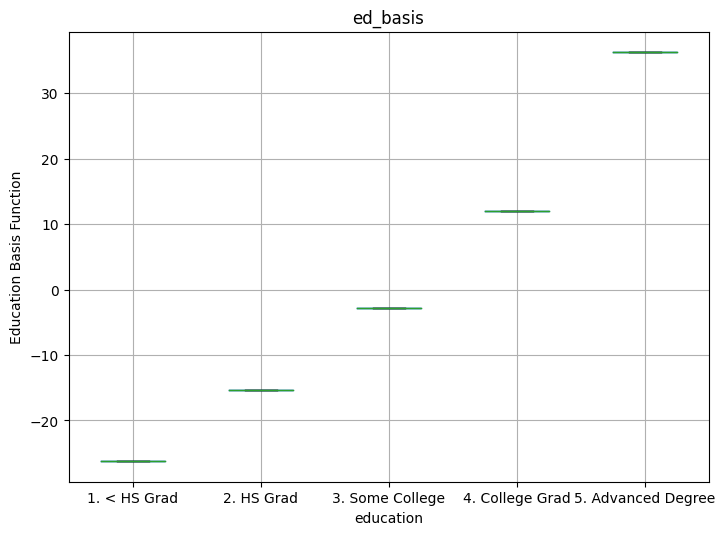

In [36]:
fig, ax1 = plt.subplots(1,1,figsize=(8,6))
df.boxplot(column='ed_basis', by='education', ax=ax1);
ax1.set_ylabel('Education Basis Function');
plt.suptitle('');

### ANOVA Test

According to the plots above, the function of `year` looks rather linear. We can perform a series of ANOVA tests in order to determine which of these three models is best: a GAM that excludes `year` (gam2), a GAM that uses a linear function of `year` (gam3), or a GAM that uses a spline function of `year` (gam)

In [37]:
df2 = dmatrix("cr(age, df=5, constraints='center') + education", data=wages,
             return_type='dataframe')

gam2 = sm.OLS(wages.wage, df2).fit()

df3 = dmatrix("year + cr(age, df=5, constraints='center') + education", data=wages,
             return_type='dataframe')

gam3 = sm.OLS(wages.wage, df3).fit()

In [38]:
table = sm.stats.anova_lm(gam2, gam3, gam, type=1)
table

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2990.0,3.712549e+06,0.0,NaN,NaN,NaN
1,2989.0,3.695015e+06,1.0,17534.011180,14.182511,0.000169
2,2986.0,3.691628e+06,3.0,3386.677223,0.913113,0.433717


We find that there is compelling evidence that a GAM with a linear function of `year` is better than a GAM does not include `year` at all (p-value=0.000169). However, there is no evidence that a non-linear func- tion of `year` is needed (p-value = 0.349). In other words, based on the results of this ANOVA, gam3 is preferred.

In [39]:
gam3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     123.5
Date:                Tue, 16 May 2023   Prob (F-statistic):          4.70e-216
Time:                        01:48:57   Log-Likelihood:                -14931.
No. Observations:                3000   AIC:                         2.988e+04
Df Residuals:                    2989   BIC:                         2.995e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                              -2316.2770    637.709     -3.632      0.000   -3566.670   -1065.884
education[T.2. HS Grad]                   11.0218      2.428      4.539      0.000       6.260      15.783
education[T.3. Some College]              23.5921      2.559      9.219      0.000      18.575      28.610
education[T.4. College Grad]              38.2053      2.544     15.018      0.000      33.217      43.194
education[T.5. Advanced Degree]           62.5466      2.761     22.658      0.000      57.134      67.959
year                                       1.1974      0.318      3.766      0.000       0.574       1.821
cr(age, df=5, constraints='center')[0]     7.7147      2.639      2.924      0.003       2.541      12.889
cr(age, df=5, constraints='center')[1]    31.0352      2.686     11.553      0.000      25.768      36.302
cr(age, df=5, constraints='center')[2]    20.7652      2.490      8.340      0.000      15.883      25.647
cr(age, df=5, constraints='center')[3]     6.0196      2.863      2.102      0.036       0.406      11.634
cr(age, df=5, constraints='center')[4]   -28.4506     11.296     -2.519      0.012     -50.599      -6.302
==============================================================================
Omnibus:                     1031.394   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5507.386
Skew:                           1.543   Prob(JB):                         0.00
Kurtosis:                       8.877   Cond. No.                     1.99e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""